In [1]:
import sys
import os, glob
sys.path.insert(0, os.path.abspath('../'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.embedding.chain_strength import uniform_torque_compensation
import dwave.inspector
from shared.graph_helper import generate_butterfly_graph,draw_graph, load_nx_graph_from, load_graphs
from shared.QiskitMaxcut import Maxcut

%matplotlib inline

DIVIDER_LENGTH = 115

In [3]:
results = {}

In [44]:
def run_qubo_with(max_cut, print_to_user=False):
    """ Run Experiments with D-WAVE """

    # ------- Run our QUBO on the QPU -------
    # Set up QPU parameters
    chain_strength = partial(uniform_torque_compensation, prefactor=2)
    num_reads = 1000
    Q = max_cut.calculate_Q_matrix()

    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler())
    response = sampler.sample_qubo(Q,
                                   chain_strength=chain_strength,
                                   num_reads=num_reads,
                                   label='QUBO {}'.format(max_cut.graph.name))

    # Inspect
    # dwave.inspector.show(response)

    # ------- Calculate distribution -------
    distribution = {}
    mean = sum([r[1] * r[2] for r in response.record]) / num_reads   
    
    most_sampled_bitstring_with_lowest_energy = ([],0, 0)
    
    for sample, E, occ, cbf in response.data(fields=['sample', 'energy', 'num_occurrences', 'chain_break_fraction']):
        if int(E) in distribution:
            distribution[int(E)] += occ
        else:
            distribution[int(E)] = occ

        
        if most_sampled_bitstring_with_lowest_energy[1] >= E:
            if most_sampled_bitstring_with_lowest_energy[2] <= occ:
                most_sampled_bitstring_with_lowest_energy = (sample.values(), E, occ)
            
            
    distribution_nn = distribution.copy()
    for e, o in distribution.items():
        if distribution[e] == 0:
            distribution_nn.pop(e)
            
    approx_ratio = mean / max_cut.opt_max_cut
    max_energy = np.max(list(distribution_nn.keys()))
    min_energy = np.min(list(distribution_nn.keys()))
    if (mean - max_energy) != 0 and (min_energy - max_energy)!= 0 : 
        ratio = (mean - max_energy) / (min_energy - max_energy)
    else:
        ratio = 0
        
    #results[name] = (mean, ratio, approx_ratio)

    if print_to_user:
    
        # ------- Plot results to user -------
        plt.clf()
        plt.bar(distribution_nn.keys(), distribution_nn.values())  # density=False would make counts
        plt.ylabel('Solution Occurrences')
        plt.xlabel('Energy')
        plt.title(f"Expectation Value (Ø: {mean:.3f})")
        plt.show()

        print(f'Highest Energy: {max_energy:.3f}')
        print(f'Lowest Energy: {min_energy:.3f}')
        print(f'Mean: {mean:.3f}')
        print(f'Approximation Ratio: {approx_ratio:.3f}')
        print(f'Ratio r: {ratio:.3f}')
        best_bitstring = np.array(list(most_sampled_bitstring_with_lowest_energy[0]))
        print(f"Most sampled solution BitString (with lowest energy): {best_bitstring}")


        # ------- Draw cut graph to user -------
        plt.clf()
        max_cut.draw(best_bitstring)
        plt.show()

    # ------- Print results to user -------
    if print_to_user:
        print('Additional Information:')
        print('ID: {:>15s}'.format(str(response.info['problem_id'])))
        print('Chain strength: {:>5s}'.format(str(response.info['embedding_context']['chain_strength'])))

        print()
        print('{:>15s}{:>15s}{:^15s}{:^15s}{:^15s}{:^15s}{:^15s}'.format('Set 0', 'Set 1', 'Energy', 'Cut Size', 'Occurrences', 'Bitstring', 'Chain Break Fraction'))
        print('-' * DIVIDER_LENGTH)
        for sample, E, occ, cbf in response.data(fields=['sample', 'energy', 'num_occurrences', 'chain_break_fraction']):
            S0 = [k for k, v in sample.items() if v == 0]
            S1 = [k for k, v in sample.items() if v == 1]
            print('{:>15s}{:>15s}{:^15s}{:^15s}{:^15s}{:^15s}{:^15s}'.format(str(S0), str(S1), str(E), str(int(-1 * E)), str(occ), ", ".join(map(str, sample.values())), str(cbf)))

    print('-' * DIVIDER_LENGTH)
    
    return mean, ratio, approx_ratio

In [45]:
import ast
dict_filename = "data/max_cuts_dict_3_reg.dict"
def get_dict():
    f = open(dict_filename, 'r')
    contents = f.read()
    dictionary = ast.literal_eval(contents)
    f.close()
    return dictionary

def get_max_cut(graph):
    dic = get_dict()
    return dic[graph]

In [46]:
def calculate_maxcut_for(graph):
    print('-' * DIVIDER_LENGTH)
    print(f"Running filename: {graph.name}")
    plt.clf()
    draw_graph(graph)
    plt.show()
    
    means = []
    rs = []
    ars = []
    
    for _ in range(0,5):
        opt_max_cut = get_max_cut(graph.name)
        max_cut = Maxcut(graph, -opt_max_cut)
        m, r, ar = run_qubo_with(max_cut)
        means.append(m)
        if r != 0:
            rs.append(r)
        ars.append(ar)
        
    results[graph.name] = (means, rs, ars)
        

In [47]:
def run_butterfly_graph():
    graph = generate_butterfly_graph()
    calculate_maxcut_for(graph)

In [48]:
#run_butterfly_graph()

In [49]:
def run_all_20():
    for file in sorted(glob.glob("../data/graphs/20_nodes/*.txt")):
        graph = load_nx_graph_from(file)
        calculate_maxcut_for(graph)

In [50]:
def run_all():
    for file in sorted(glob.glob("data/*.txt")):
        graph = load_nx_graph_from(file)
        calculate_maxcut_for(graph)

-------------------------------------------------------------------------------------------------------------------
Running filename: graph_05_06_02


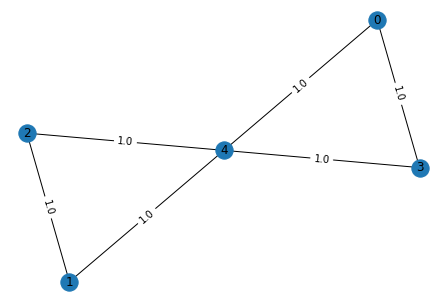

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_05_06_02_w


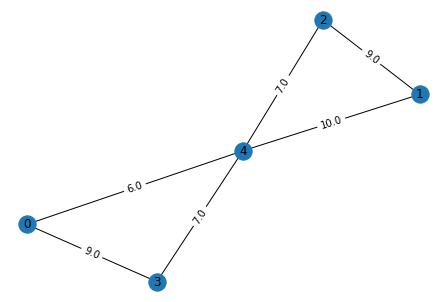

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_3_reg_04_06_01


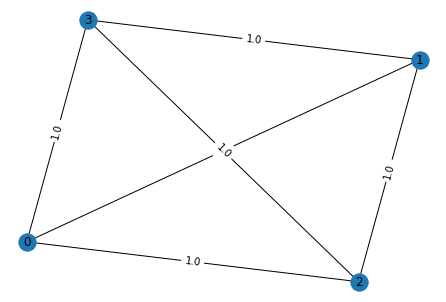

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_3_reg_04_06_w_01


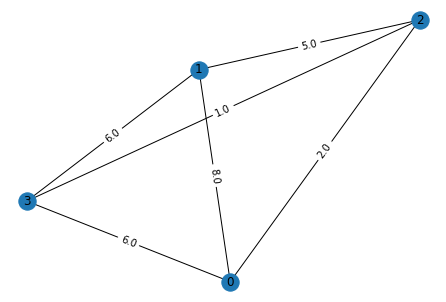

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_3_reg_06_09_01


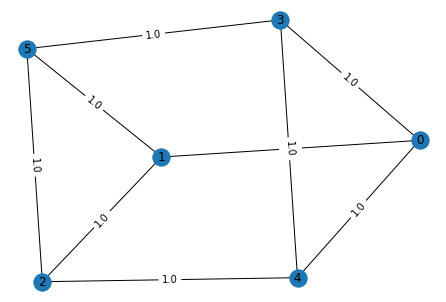

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_3_reg_06_09_w_01


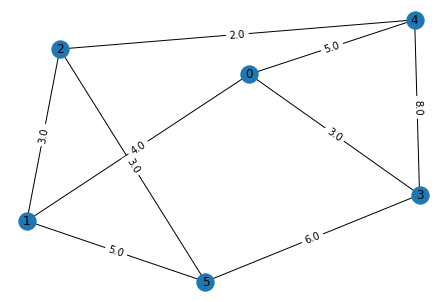

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_3_reg_08_12_01


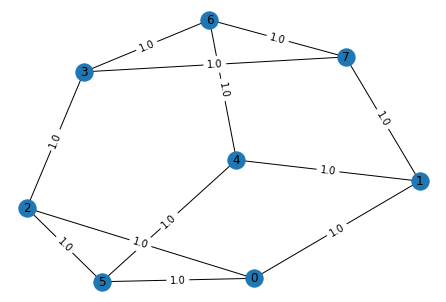

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_3_reg_08_12_w_01


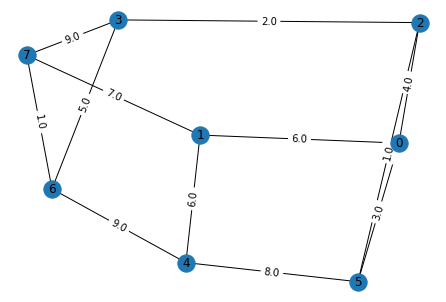

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------


In [51]:
run_all()

In [52]:
results

{'graph_05_06_02': ([-4.0, -4.0, -4.0, -4.0, -4.0],
  [],
  [1.0, 1.0, 1.0, 1.0, 1.0]),
 'graph_05_06_02_w': ([-34.29, -34.38, -34.408, -34.375, -34.231],
  [0.8579999999999999,
   0.8966666666666671,
   0.8520000000000003,
   0.875,
   0.8718333333333336],
  [0.9797142857142856,
   0.9822857142857143,
   0.9830857142857143,
   0.9821428571428571,
   0.9780285714285715]),
 'graph_3_reg_04_06_01': ([-4.0, -4.0, -4.0, -4.0, -4.0],
  [],
  [1.0, 1.0, 1.0, 1.0, 1.0]),
 'graph_3_reg_04_06_w_01': ([-19.584, -19.642, -19.659, -19.647, -19.669],
  [0.8959999999999999,
   0.9104999999999999,
   0.9147499999999997,
   0.9495714285714284,
   0.9172500000000001],
  [0.9792, 0.9821, 0.98295, 0.98235, 0.98345]),
 'graph_3_reg_06_09_01': ([-6.998, -7.0, -6.998, -7.0, -7.0],
  [0.9990000000000001, 0.9980000000000002],
  [0.9997142857142858, 1.0, 0.9997142857142858, 1.0, 1.0]),
 'graph_3_reg_06_09_w_01': ([-30.814, -30.865, -30.788, -30.827, -30.803],
  [0.969, 0.9729999999999996, 0.9576, 0.95675000000

In [53]:
import pickle
def save_dict(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_dict(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [55]:
name = 'result_benchmark_5_dict'

In [56]:
save_dict(results, name)

In [57]:
results = load_dict(name)

In [58]:
import pandas as pd

In [59]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Expectation Value', 'Ratio r', 'Approximation Ratio'])
results_df

,Expectation Value,Ratio r,Approximation Ratio
graph_05_06_02,"[-4.0, -4.0, -4.0, -4.0, -4.0]",[],"[1.0, 1.0, 1.0, 1.0, 1.0]"
graph_05_06_02_w,"[-34.29, -34.38, -34.408, -34.375, -34.231]","[0.8579999999999999, 0.8966666666666671, 0.852...","[0.9797142857142856, 0.9822857142857143, 0.983..."
graph_3_reg_04_06_01,"[-4.0, -4.0, -4.0, -4.0, -4.0]",[],"[1.0, 1.0, 1.0, 1.0, 1.0]"
graph_3_reg_04_06_w_01,"[-19.584, -19.642, -19.659, -19.647, -19.669]","[0.8959999999999999, 0.9104999999999999, 0.914...","[0.9792, 0.9821, 0.98295, 0.98235, 0.98345]"
graph_3_reg_06_09_01,"[-6.998, -7.0, -6.998, -7.0, -7.0]","[0.9990000000000001, 0.9980000000000002]","[0.9997142857142858, 1.0, 0.9997142857142858, ..."
graph_3_reg_06_09_w_01,"[-30.814, -30.865, -30.788, -30.827, -30.803]","[0.969, 0.9729999999999996, 0.9576, 0.95675000...","[0.994, 0.9956451612903225, 0.9931612903225806..."
graph_3_reg_08_12_01,"[-10.0, -9.824, -10.0, -9.997, -10.0]","[0.9413333333333332, 0.999]","[1.0, 0.9823999999999999, 1.0, 0.9997, 1.0]"
graph_3_reg_08_12_w_01,"[-52.445, -52.352, -52.426, -51.401, -52.451]","[0.9075000000000001, 0.9351999999999997, 0.918...","[0.9895283018867924, 0.9877735849056604, 0.989..."


In [60]:
results_df_not_w = results_df.drop([x for x in results_df.index.values if 'w' in x])
results_df_not_w

,Expectation Value,Ratio r,Approximation Ratio
graph_05_06_02,"[-4.0, -4.0, -4.0, -4.0, -4.0]",[],"[1.0, 1.0, 1.0, 1.0, 1.0]"
graph_3_reg_04_06_01,"[-4.0, -4.0, -4.0, -4.0, -4.0]",[],"[1.0, 1.0, 1.0, 1.0, 1.0]"
graph_3_reg_06_09_01,"[-6.998, -7.0, -6.998, -7.0, -7.0]","[0.9990000000000001, 0.9980000000000002]","[0.9997142857142858, 1.0, 0.9997142857142858, ..."
graph_3_reg_08_12_01,"[-10.0, -9.824, -10.0, -9.997, -10.0]","[0.9413333333333332, 0.999]","[1.0, 0.9823999999999999, 1.0, 0.9997, 1.0]"


In [61]:
results_df_w = results_df.drop([x for x in results_df.index.values if 'w' not in x])
results_df_w

,Expectation Value,Ratio r,Approximation Ratio
graph_05_06_02_w,"[-34.29, -34.38, -34.408, -34.375, -34.231]","[0.8579999999999999, 0.8966666666666671, 0.852...","[0.9797142857142856, 0.9822857142857143, 0.983..."
graph_3_reg_04_06_w_01,"[-19.584, -19.642, -19.659, -19.647, -19.669]","[0.8959999999999999, 0.9104999999999999, 0.914...","[0.9792, 0.9821, 0.98295, 0.98235, 0.98345]"
graph_3_reg_06_09_w_01,"[-30.814, -30.865, -30.788, -30.827, -30.803]","[0.969, 0.9729999999999996, 0.9576, 0.95675000...","[0.994, 0.9956451612903225, 0.9931612903225806..."
graph_3_reg_08_12_w_01,"[-52.445, -52.352, -52.426, -51.401, -52.451]","[0.9075000000000001, 0.9351999999999997, 0.918...","[0.9895283018867924, 0.9877735849056604, 0.989..."


In [62]:
import matplotlib.pyplot as plt

In [105]:
labels = [v.split('0')[1][0] + 'w' if 'w' in v else v.split('0')[1][0] for v in results_df.index.values]

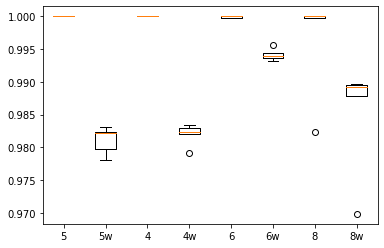

In [112]:
plt.boxplot(results_df.iloc[:,2].values, labels=labels,)
plt.show()

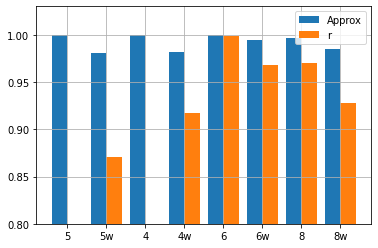

In [151]:
# für einzelne means 
means = [ np.mean(v) for v in results_df.iloc[:,2].values ]
means_r = [ np.mean(v) for v in results_df.iloc[:,1].values ]
#results_df.plot(kind="bar", y=["Approximation Ratio", "Ratio r"], ylim=[0.8, 1.03]).grid()
plt.bar(X_axis-0.2, means,0.4, label ="Approx")
plt.bar(X_axis+0.2, means_r,0.4, label ="r")
plt.xticks(rotation='horizontal')
X_axis = np.arange(len(labels))
plt.xticks(X_axis, labels)
plt.ylim([0.8, 1.03])
plt.grid()
plt.legend()
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'graph_05_06_02'),
  Text(1, 0, 'graph_05_06_02_w'),
  Text(2, 0, 'graph_3_reg_04_06_01'),
  Text(3, 0, 'graph_3_reg_04_06_w_01'),
  Text(4, 0, 'graph_3_reg_06_09_01'),
  Text(5, 0, 'graph_3_reg_06_09_w_01'),
  Text(6, 0, 'graph_3_reg_08_12_01'),
  Text(7, 0, 'graph_3_reg_08_12_w_01')])

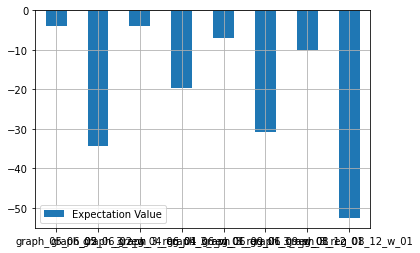

In [40]:
p = results_df.plot(kind="bar", y=["Expectation Value"]).grid()
plt.xticks(rotation='horizontal')